# 2020 Kentucky Primaries — Voter Suppression?

Leading up to the Kentucky primary elections on 2020-06-23, many of us learned what Kentucky residents allegedly had learned months prior: the number of polling sites would be dramatically reduced relative to previous years.  The given justification for the change was that COVID-19 rightly scared off many potential polling place volunteers.

If your head isn't buried in the sand, you know that voter suppression is a serious issue throughout the country.  Here we briefly search for evidence that limited polling sites could disproportionately affect marginalized populations.

This **is not** a comprehensive study.  I'm making it public mostly to demonstrate how to assemble a relevant dataset.  Social scientists can and should perform more authoritative work on this subject.

## Setup

The general strategy is:
* Scrape the polling site data with Selenium/Firefox
* Attempt to map polling addresses to (latitude,longitude) with geopy/Nominatim; fall back on generic zipcode coordinates
* Join with demographic data
* Make some plots

In [1]:
# scipy stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scraping the polling site list
from selenium import webdriver
import time
from bs4 import BeautifulSoup

# geography extraction and plotting
from geopy.location import Location
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import lru_cache
import geopandas

# progress bar
from tqdm import tqdm

In [2]:
plt.rc('figure', facecolor='w', dpi=100)

Nominatim's free geocoding service comes at the cost of flexibility.  Clients are entirely responsible for rate-limiting and caching, otherwise risking a temporary block.  We set up a caching, rate-limiting `geocode()` accordingly:

In [3]:
locator = Nominatim(user_agent='mike_richman_kentucky_addresses')
geocode = lru_cache()(RateLimiter(locator.geocode, min_delay_seconds=1))

Some more odds-and-ends: a helper function for parsing the address format we will receive, and a zipcode table to use as a fallback when address geocoding fails.

In [4]:
def address_to_text(address):
    return ', '.join(address.text.split('\n')[-2:])

In [5]:
zipcodes = pd.read_csv('https://gist.github.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')
zipcodes['zip'] = [f'{z:05d}' for z in zipcodes.ZIP]

In [6]:
zipcodes.head()

,ZIP,LAT,LNG,zip
0,601,18.180555,-66.749961,00601
1,602,18.361945,-67.175597,00602
2,603,18.455183,-67.119887,00603
3,606,18.158345,-66.932911,00606
4,610,18.295366,-67.125135,00610


In [7]:
ziplats = dict(zip(zipcodes.zip, zipcodes.LAT))
ziplons = dict(zip(zipcodes.zip, zipcodes.LNG))

## Scraping the polling locations

The polling locations are (or were?) documented at https://www.sos.ky.gov/elections/Pages/Polling-Locations.aspx.  The page starts out empty before being populated.  Rather than filling in the "form" (selecting "County..." instead of a specific county such as "Adair"), we'll let Selenium spawn a Firefox instance so it happens automatically.

In [8]:
browser = webdriver.Firefox()
browser.get('https://www.sos.ky.gov/elections/Pages/Polling-Locations.aspx')
time.sleep(3)
source = browser.page_source
browser.quit()

Next up, we scrape the addresses.  The following is the result of looking through the DOM and Style Inspector, combined with a little trial and error.

In [9]:
page = BeautifulSoup(source, 'html.parser')

for br in page.find_all('br'):
    br.replace_with('\n')
    
counties = page.find_all('div', class_='location')

addresses_by_county = {}
all_addresses = []
all_counties = []
for county in counties:
    county_name = county.attrs['data-county']
    elements = county.find_all()
    while elements and elements[0].name != 'hr':
        elements.pop(0)
    addresses = [address_to_text(element) for element in elements if element.name == 'address']
    all_addresses.extend(addresses)
    all_counties.extend(len(addresses) * [county_name])
    addresses_by_county[county_name] = addresses

We pack the data into a DataFrame and perform the geocoding (takes a few minutes, given the rate-limiting above).

In [10]:
sites = pd.DataFrame(dict(county=all_counties, address=all_addresses))

In [11]:
sites['geocode'] = [geocode(a) for a in tqdm(sites.address)]

100%|██████████| 168/168 [03:50<00:00,  1.37s/it]


Now we prefer the geocoding location, but accept the generic zipcode, for each polling site.  For a few locations, geocoding failed and the zipcode wasn't correctly parsed, so we fill these in as special cases.

In [12]:
sites['geocode'] = [np.nan if g is None else g for g in sites.geocode]

In [13]:
sites['zip'] = sites.address.str.extract(r'(\d{5})$')

In [14]:
sites['latitude'] = [
    g.latitude if hasattr(g, 'latitude') else ziplats[z] if z in ziplats else np.nan
    for (g, z) in zip(sites.geocode, sites.zip)]
sites['longitude'] = [
    g.longitude if hasattr(g, 'longitude') else ziplons[z] if z in ziplons else np.nan
    for (g, z) in zip(sites.geocode, sites.zip)]

# 59 Hardin 150 N. Provident Way, Elizabethtown, KY
sites['latitude'].values[59], sites['longitude'].values[59] = 37.7178805,-85.9023369
# 61 Harrison US Highway 27, Cynthiana, KY
sites['latitude'].values[61], sites['longitude'].values[61] = 38.3527995,-84.3135513
# 98 Madison 75 Old US Highway 25, Berea, KY
sites['latitude'].values[98], sites['longitude'].values[98] = 37.5902269,-84.2688203

# latitude, longitude in radians in case we need it
sites['lat'] = np.radians(sites.latitude)
sites['lon'] = np.radians(sites.longitude)

Now we have a table of polling sites with coordinates that can be plotted.

In [15]:
sites

,county,address,geocode,zip,latitude,longitude,lat,lon
0,Adair,"424 Public Square, Columbia, KY 42728",NaN,42728,37.117031,-85.290070,0.647814,-1.488593
1,Allen,"934 Old Glasgow Road, Scottsville, KY 42164","(Old Glasgow Road, Scottsville, Allen County, ...",42164,36.772387,-86.166774,0.641799,-1.503894
2,Anderson,"1026 County Park Rd., Lawrenceburg, KY 40342","(1026, County Park Road, Lawrenceburg, Anderso...",40342,38.038833,-84.908277,0.663903,-1.481929
3,Ballard,"132 N. 4th Street, Wickliffe, KY 42087","(4th Street, Wickliffe, Ballard County, Kentuc...",42087,36.964259,-89.089291,0.645148,-1.554901
4,Barren,"507 Trojan Trail, Glasgow, KY 42141","(Trojan Trail, Glasgow, Barren County, Kentuck...",42141,36.977943,-85.923072,0.645387,-1.499641
...,...,...,...,...,...,...,...,...
163,Wayne,"2 Kenny Davis Blvd, Monticello, KY","(2, Kenny Davis Boulevard, Monticello, Wayne C...",NaN,36.830687,-84.866534,0.642817,-1.481200
164,Webster,"101 St Rt 132, Dixon, KY 42409",NaN,42409,37.538637,-87.692934,0.655173,-1.530530
165,Whitley,"350 Blvd. of Champions, Williamsburg, KY 40769",NaN,40769,36.703266,-84.197082,0.640593,-1.469516
166,Whitley,"3551 5th Street, Corbin, KY 40701",NaN,40701,36.921744,-84.157710,0.644406,-1.468829


We're going to analyze number of polling sites per county, so we make a separate table for that.

In [16]:
site_counts = sites.groupby('county').apply(lambda x: pd.Series(dict(
    num_sites = x.address.nunique()
))).reset_index()
site_counts.head()

,county,num_sites
0,Adair,1
1,Allen,1
2,Anderson,1
3,Ballard,1
4,Barren,1


## Population Data

Piggy-back off of the population dataset assembled for my COVID-19 investigations, see [here](https://github.com/zgana/coronavirus).

In [17]:
pop = pd.read_csv('/home/mike/ds/coronavirus/data/pop/pop-estimates-2019.csv')
pop = pop[pop.state_name.eq('Kentucky') & pop.fips_county.ne(0)]
pop['name'] = pop.county_name.str.replace(' County', '')

In [18]:
pop

,fips,fips_state,fips_county,state_name,county_name,population,land_area,population_density,population_weighted_density,name
1010,21001,21,1,Kentucky,Adair County,19202,412.25,46.578532,46.578532,Adair
1011,21003,21,3,Kentucky,Allen County,21315,352.06,60.543657,60.543657,Allen
1012,21005,21,5,Kentucky,Anderson County,22747,204.30,111.341165,111.341165,Anderson
1013,21007,21,7,Kentucky,Ballard County,7888,273.62,28.828302,28.828302,Ballard
1014,21009,21,9,Kentucky,Barren County,44249,499.95,88.506851,88.506851,Barren
...,...,...,...,...,...,...,...,...,...,...
1125,21231,21,231,Kentucky,Wayne County,20333,484.22,41.991244,41.991244,Wayne
1126,21233,21,233,Kentucky,Webster County,12942,335.70,38.552279,38.552279,Webster
1127,21235,21,235,Kentucky,Whitley County,36264,445.17,81.461015,81.461015,Whitley
1128,21237,21,237,Kentucky,Wolfe County,7157,222.88,32.111450,32.111450,Wolfe


## County Geometry

This is probably the us_counties.json file floating around on the internet... sorry, forgot to note the source.

In [19]:
%%time
us_counties = geopandas.read_file('data/counties.json', encoding='latin1')

CPU times: user 348 ms, sys: 15.5 ms, total: 364 ms
Wall time: 390 ms


In [20]:
ky_counties = us_counties[us_counties.state_id.eq(21)]

In [21]:
print(ky_counties.shape)
ky_counties.head()

(120, 7)


,id,name,AFFGEOID,fips_id,state_id,is_a_state,geometry
993,cb_2018_us_county_20m.kml,Adair,0500000US21001,21001,21,False,"POLYGON Z ((-85.52688 37.10945 0.00000, -85.50..."
994,cb_2018_us_county_20m.kml,Allen,0500000US21003,21003,21,False,"POLYGON Z ((-86.41898 36.67627 0.00000, -86.41..."
995,cb_2018_us_county_20m.kml,Anderson,0500000US21005,21005,21,False,"POLYGON Z ((-85.16919 37.99792 0.00000, -85.16..."
996,cb_2018_us_county_20m.kml,Ballard,0500000US21007,21007,21,False,"POLYGON Z ((-89.16809 37.07422 0.00000, -89.16..."
997,cb_2018_us_county_20m.kml,Barren,0500000US21009,21009,21,False,"POLYGON Z ((-86.11351 37.06107 0.00000, -86.16..."


## Income data

We can get income data from Wikipedia:

In [22]:
income = pd.read_html('https://en.wikipedia.org/wiki/List_of_Kentucky_locations_by_per_capita_income')[1]
income.columns = (
    'rank name per_capita_income household_median_income family_median_income population num_households'
).split()
income = income.drop(columns='rank population'.split())
for col in 'per_capita_income household_median_income family_median_income'.split():
    income[col] = income[col].str.replace('[$,]', '').astype(int)

In [23]:
income

,name,per_capita_income,household_median_income,family_median_income,num_households
0,Oldham,32702,79417,89911,19431
1,Boone,28520,66549,77474,43216
2,Woodford,28501,56537,67094,9806
3,Fayette,28345,47469,66690,123043
4,Shelby,27593,55296,68647,15321
...,...,...,...,...,...
117,Lee,12983,25129,32862,2910
118,Clay,12300,20175,28862,7732
119,McCreary,12197,22643,26421,6477
120,Wolfe,11214,20910,22489,3065


## Racial Makeup

The US census provides fairly granular racial data.  We won't get into the problems with relying on this data; we just assume that it's enough to give us a clue.

In [24]:
! wget https://www2.census.gov/programs-surveys/popest/tables/2010-2018/counties/asrh/PEP_2018_PEPSR6H.zip
! unzip PEP_2018_PEPSR6H.zip PEP_2018_PEPSR6H_with_ann.csv
! mv PEP_2018_PEPSR6H_with_ann.csv data/kentucky_racial_makeup_us_census.csv
! rm PEP_2018_PEPSR6H.zip

--2020-07-03 14:30:05--  https://www2.census.gov/programs-surveys/popest/tables/2010-2018/counties/asrh/PEP_2018_PEPSR6H.zip
Resolving www2.census.gov (www2.census.gov)... 2600:1408:8c00:2a3::208c, 2600:1408:8c00:298::208c, 184.25.191.212
Connecting to www2.census.gov (www2.census.gov)|2600:1408:8c00:2a3::208c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘PEP_2018_PEPSR6H.zip’

PEP_2018_PEPSR6H.zi     [      <=>           ]   5.03M   882KB/s    in 5.8s    

2020-07-03 14:30:11 (885 KB/s) - ‘PEP_2018_PEPSR6H.zip’ saved [5274336]

Archive:  PEP_2018_PEPSR6H.zip
  inflating: PEP_2018_PEPSR6H_with_ann.csv  


We're going to gloss over the distinction between Hispanic/non-Hispanic ethnicity versus other races.  First we rename and clean some columns:

In [25]:
race = pd.read_csv('data/kentucky_racial_makeup_us_census.csv',
                   encoding='latin1', low_memory=False)
race = race[
    race['Year.display-label'].eq(race['Year.display-label'].iloc[-1])]
race.columns = (
    'year_id date sex Sex hispanic Hispanic geoid fips name'
    ' total white_only black_only native_only asian_only islander_only multiple'
).split()
race = race[
    race.name.str.contains('Kentucky')
    & race.hispanic.ne('tothisp')
    & race.sex.eq('totsex')
]
race = race.drop(columns='year_id date Sex Hispanic geoid'.split())
race['name'] = race.name.str.replace(' County, Kentucky', '')
for col in 'total white_only black_only native_only asian_only islander_only multiple'.split():
    race[col] = race[col].astype(int)

In [26]:
race.sort_values('name').head(20)

,sex,hispanic,fips,name,total,white_only,black_only,native_only,asian_only,islander_only,multiple
98404,totsex,hisp,21001,Adair,387,324,15,7,7,6,28
98405,totsex,nhisp,21001,Adair,18828,17902,556,47,73,3,247
98503,totsex,hisp,21003,Allen,466,409,15,9,1,2,30
98504,totsex,nhisp,21003,Allen,20656,20022,244,59,57,1,273
98602,totsex,hisp,21005,Anderson,409,350,18,14,4,6,17
98603,totsex,nhisp,21005,Anderson,22254,21253,466,41,126,3,365
98701,totsex,hisp,21007,Ballard,113,97,1,7,2,0,6
98702,totsex,nhisp,21007,Ballard,7866,7364,268,18,36,1,179
98800,totsex,hisp,21009,Barren,1453,1112,65,77,37,65,97
98801,totsex,nhisp,21009,Barren,42723,39785,1793,80,386,24,655


And then we count up the absolute and relative totals per race per county:

In [27]:
race_counts = race.groupby('name').apply(lambda x: pd.Series(dict(
    multiple=x.multiple[x.hispanic.eq('nhisp')].sum(),
    islander=x.islander_only[x.hispanic.eq('nhisp')].sum(),
    asian=x.asian_only[x.hispanic.eq('nhisp')].sum(),
    hispanic=x.total[x.hispanic.eq('hisp')].sum(),
    black=x.black_only[x.hispanic.eq('nhisp')].sum(),
    white=x.white_only[x.hispanic.eq('nhisp')].sum(),
    total=x.total.sum(),
))).reset_index()
race_counts['nonwhite'] = race_counts.total - race_counts.white
for col in race_counts.columns[1:]:
    if col == 'total':
        continue
    race_counts[f'frac_{col}'] = race_counts[col] / race_counts.total

In [28]:
race_counts

,name,multiple,islander,asian,hispanic,black,white,total,nonwhite,frac_multiple,frac_islander,frac_asian,frac_hispanic,frac_black,frac_white,frac_nonwhite
0,Adair,247,3,73,387,556,17902,19215,1313,0.012855,0.000156,0.003799,0.020141,0.028936,0.931668,0.068332
1,Allen,273,1,57,466,244,20022,21122,1100,0.012925,0.000047,0.002699,0.022062,0.011552,0.947922,0.052078
2,Anderson,365,3,126,409,466,21253,22663,1410,0.016106,0.000132,0.005560,0.018047,0.020562,0.937784,0.062216
3,Ballard,179,1,36,113,268,7364,7979,615,0.022434,0.000125,0.004512,0.014162,0.033588,0.922923,0.077077
4,Barren,655,24,386,1453,1793,39785,44176,4391,0.014827,0.000543,0.008738,0.032891,0.040588,0.900602,0.099398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Wayne,274,3,78,707,337,19024,20468,1444,0.013387,0.000147,0.003811,0.034542,0.016465,0.929451,0.070549
116,Webster,205,27,51,754,500,11544,13111,1567,0.015636,0.002059,0.003890,0.057509,0.038136,0.880482,0.119518
117,Whitley,455,11,161,468,296,34753,36242,1489,0.012554,0.000304,0.004442,0.012913,0.008167,0.958915,0.041085
118,Wolfe,73,0,9,71,24,6976,7177,201,0.010171,0.000000,0.001254,0.009893,0.003344,0.971994,0.028006


## Merged data

Finally we can build a merged dataset, lazily named `d`.

In [29]:
d = data = ky_counties \
    .merge(site_counts, left_on='name', right_on='county', how='left') \
    .merge(pop['name land_area population population_density'.split()], on='name', how='left') \
    .merge(income, on='name', how='left') \
    .merge(race_counts, on='name', how='left')
d['num_sites'] = d.num_sites.fillna(0)
d['sites_per_mille'] = d.num_sites / (d.population/1e3)
d['sites_per_mi2'] = d.num_sites / d.land_area

In [30]:
d.drop(columns='geometry').head()

,id,name,AFFGEOID,fips_id,state_id,is_a_state,county,num_sites,land_area,population,...,nonwhite,frac_multiple,frac_islander,frac_asian,frac_hispanic,frac_black,frac_white,frac_nonwhite,sites_per_mille,sites_per_mi2
0,cb_2018_us_county_20m.kml,Adair,0500000US21001,21001,21,False,Adair,1.0,412.25,19202,...,1313,0.012855,0.000156,0.003799,0.020141,0.028936,0.931668,0.068332,0.052078,0.002426
1,cb_2018_us_county_20m.kml,Allen,0500000US21003,21003,21,False,Allen,1.0,352.06,21315,...,1100,0.012925,0.000047,0.002699,0.022062,0.011552,0.947922,0.052078,0.046915,0.002840
2,cb_2018_us_county_20m.kml,Anderson,0500000US21005,21005,21,False,Anderson,1.0,204.30,22747,...,1410,0.016106,0.000132,0.005560,0.018047,0.020562,0.937784,0.062216,0.043962,0.004895
3,cb_2018_us_county_20m.kml,Ballard,0500000US21007,21007,21,False,Ballard,1.0,273.62,7888,...,615,0.022434,0.000125,0.004512,0.014162,0.033588,0.922923,0.077077,0.126775,0.003655
4,cb_2018_us_county_20m.kml,Barren,0500000US21009,21009,21,False,Barren,1.0,499.95,44249,...,4391,0.014827,0.000543,0.008738,0.032891,0.040588,0.900602,0.099398,0.022599,0.002000


## Maps

Here are some choropleth maps:

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

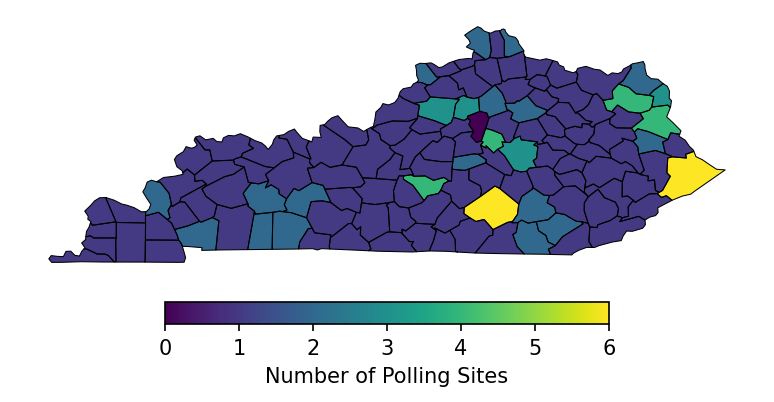

In [31]:
fig, ax = plt.subplots(dpi=150)
d = data
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot('num_sites', ax=ax, lw=0, cmap='viridis', legend=True,
       legend_kwds=dict(
           orientation='horizontal', label='Number of Polling Sites', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

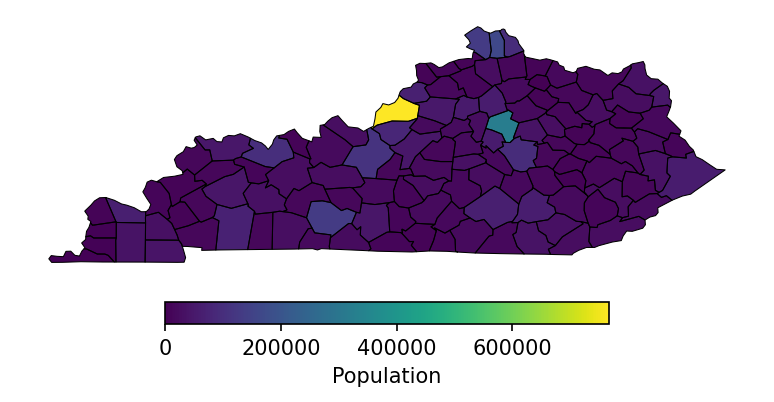

In [32]:
fig, ax = plt.subplots(dpi=150)
d = data
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot('population', ax=ax, lw=0, cmap='viridis', vmin=0,
       legend=True, legend_kwds=dict(
           orientation='horizontal', label='Population', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

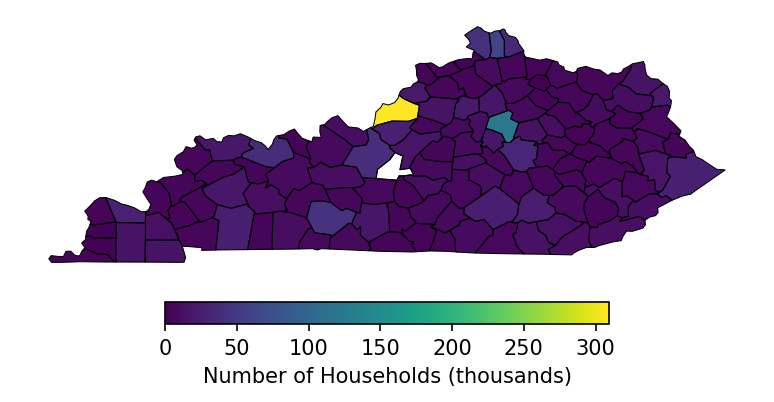

In [33]:
fig, ax = plt.subplots(dpi=150)
d = data
z = d.num_households / 1e3
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot(z, ax=ax, lw=0, cmap='viridis', vmin=0,
       legend=True, legend_kwds=dict(
           orientation='horizontal', label='Number of Households (thousands)', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

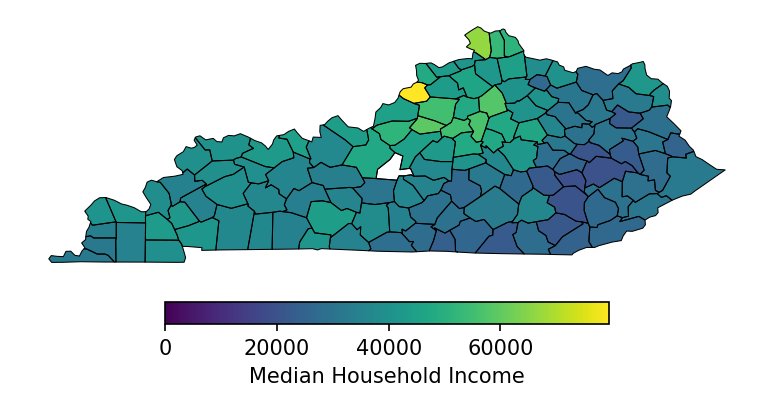

In [34]:
fig, ax = plt.subplots(dpi=150)
d = data
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot('household_median_income', ax=ax, lw=0, cmap='viridis', vmin=0,
       legend=True, legend_kwds=dict(
           orientation='horizontal', label='Median Household Income', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

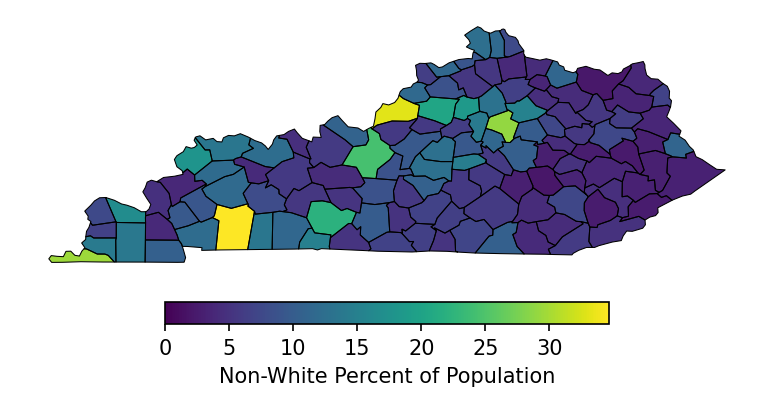

In [35]:
fig, ax = plt.subplots(dpi=150)
d = data
z = d.frac_nonwhite * 100
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot(z, ax=ax, lw=0, cmap='viridis', vmin=0,
       legend=True, legend_kwds=dict(
           orientation='horizontal', label='Non-White Percent of Population', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

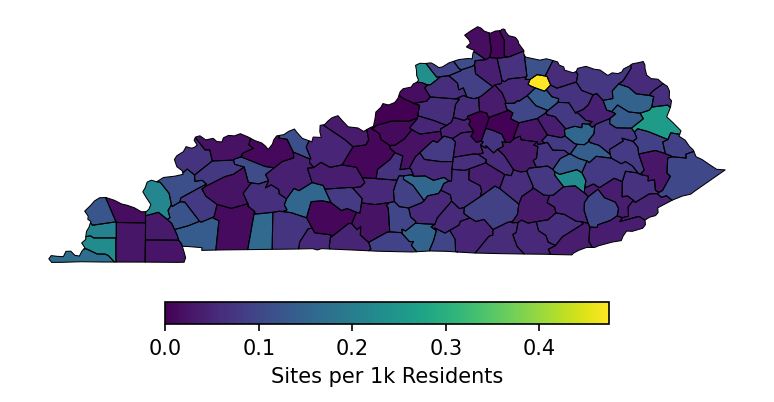

In [36]:
fig, ax = plt.subplots(dpi=150)
d = data
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot('sites_per_mille', ax=ax, lw=0, cmap='viridis', vmin=0,
       legend=True, legend_kwds=dict(
           orientation='horizontal', label='Sites per 1k Residents', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

(-89.9516402, -81.58813780000001, 36.3654628, 39.279829199999995)

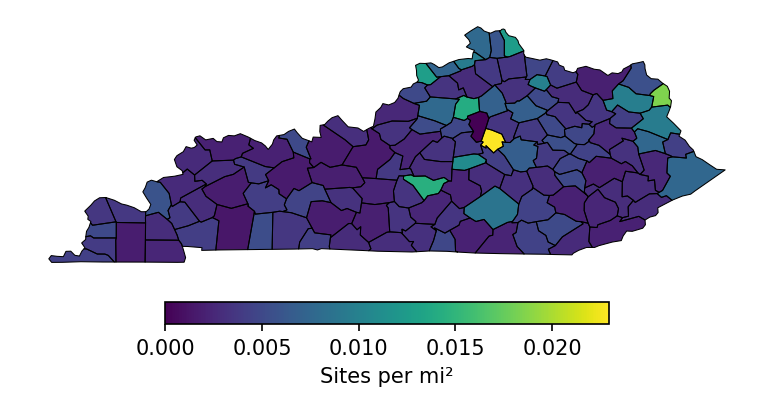

In [37]:
fig, ax = plt.subplots(dpi=150)
d = data
d.boundary.plot(color='k', lw=.5, ax=ax)
d.plot('sites_per_mi2', ax=ax, lw=0, cmap='viridis', vmin=0,
       legend=True, legend_kwds=dict(
           orientation='horizontal', label='Sites per mi²', fraction=.04, pad=.05, ax=ax))
ax.axis('off')

The strongest correlations/anti-correlations are, unsurprisngly, between features that are based on each other — e.g. `num_sites`/`sites_per_mi2`, `population`/`num_households`, `frac_white`/`frac_nonwhite`.

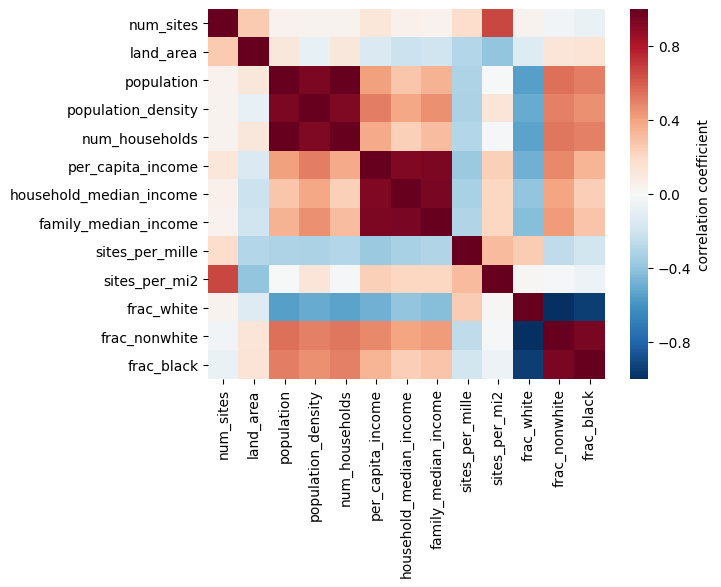

In [38]:
cols = (
    'num_sites land_area population population_density num_households'
    ' per_capita_income household_median_income family_median_income'
    ' sites_per_mille sites_per_mi2'
    ' frac_white frac_nonwhite frac_black'
).split()
ax = sns.heatmap(data[cols].corr(), vmin=-1, vmax=1,
                 cmap='RdBu_r', cbar_kws=dict(label='correlation coefficient'))

The one interesting finding is that sites per mille (i.e. per 1000 residents) is correlated with fraction of county that is white, while anti-correlated with fraction of county that is non-white.

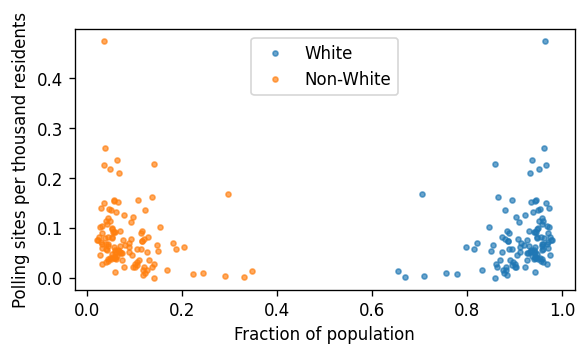

In [39]:
plt.figure(figsize=(5,3), dpi=120)
plt.plot(data.frac_white, data.sites_per_mille, '.', label='White', alpha=.66)
plt.plot(data.frac_nonwhite, data.sites_per_mille, '.', label='Non-White', alpha=.66)
plt.xlabel('Fraction of population')
plt.ylabel('Polling sites per thousand residents')
plt.legend(loc='upper center')
plt.tight_layout()

(0.01, 1)

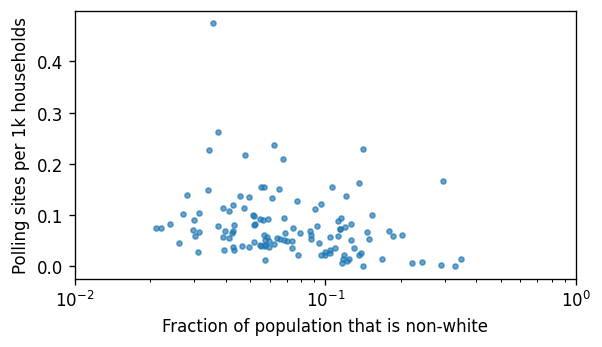

In [40]:
plt.figure(figsize=(5,3), dpi=120)
plt.plot(data.frac_nonwhite, data.sites_per_mille, '.', label='Non-White', alpha=.66)
plt.xlabel('Fraction of population that is non-white')
plt.ylabel('Polling sites per 1k households')
plt.semilogx()
plt.tight_layout()
plt.xlim(.01, 1)

I expected that perhaps sites per mille would also be correlated with income, but in fact it seems the reverse is (to some extent) true.

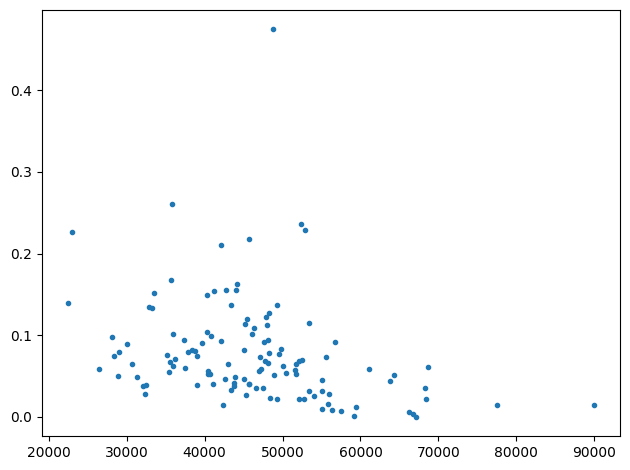

In [41]:
fig, ax = plt.subplots()
ax.plot(data.family_median_income, data.sites_per_mille, '.')
#ax.semilogx()
plt.tight_layout()

In [42]:
data['family_median_income sites_per_mille'.split()].corr()

,family_median_income,sites_per_mille
family_median_income,1.000000,-0.301502
sites_per_mille,-0.301502,1.000000


## Conclusions?

It's hard to draw any hard conclusions from the cursory study here.  We didn't do much analysis after constructing the dataset.

If anything, we might draw a preliminary conclusion that any bias in number of polling sites is tracking race more than economic status.

Further investigation should consider not only the small set of polling sites in this one election but how that ensemble differs from polling sites in previous elections.